# Setup

In [1]:
%cd /content/gdrive/My Drive/PerfPred/repo

/content/gdrive/.shortcut-targets-by-id/1vr6Z8seuUA0zoWaHuosCSZMv_H2Go5KR/PerfPred/repo


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
import sys
sys.path.append('/content/gdrive/My Drive/PerfPred/repo/src')

In [4]:
from trial import *
from expr.trial_util import *
from expr.train_size import *
from expr.domain_div import *

# Documentations (for Reference)

## Trial Functions

### Single Variable

#### Linear

$$f(X) = \alpha X + C$$

```
def linear_single(c, x):
  """
  c: Array with dim 2, corresponding to alpha, C.
  x: Array with dim (n, 1).
  y: Array with dim n.
  """
```

#### Log

$$f(X) = C\log(\alpha X) + \beta$$
where $\alpha > 0$. \\
Idea from [Sriivasan's paper, p.4](https://arxiv.org/pdf/2110.08875.pdf).

```
def log_single(c, x):
  """
  c: Array with dim 3, corresponding to C, alpha, beta.
  x: Array with dim (n, 1).
  y: Array with dim n.
  """
```

#### Google Paper Law

$$f(X) = \alpha\left(\frac1X + C\right)^p$$
where $C > 0$. \\
Idea from [Bansal's paper](https://arxiv.org/pdf/2202.01994.pdf), p.3.

```
def recip_single(c, x):
  """
  c: Array with dim 3, corresponding to alpha, C, p.
  x: Array with dim (n, 1).
  y: Array with dim n.
  """
```

### Double Variable

#### Linear

$$f(X) = \beta_1 X_1 + \beta_2 X_2 + C$$
Idea: Simple linear.

```
def linear_double(c, x):
  """
  c: Array with dim 3, corresponding to beta1, beta2, C.
  x: Array with dim (n, 2).
  y: Array with dim n.
  """
```

#### Product

$$f(X) = \alpha (X_1)^{-p_1} \cdot (X_2)^{-p_2} + C$$
where $\alpha < 0, p_1, p_2, C > 0$. \\
See curve-fitting > equation in [Anthony's work](https://colab.research.google.com/drive/1Rx6sExWQ9RsNQeoHwBSmzIP2D-XvtMRy#scrollTo=aC47KqM31nLO).

```
def product_double(c, x):
  """
  c: Array with dim 4, corresponding to alpha, p1, p2, C.
  x: Array with dim (n, 2).
  y: Array with dim n.
  """
```

#### Anthony's Paper Law

$$f(X) = \alpha_1 (X_1X_2)^{-p_1} + \alpha_2 X_2 ^ {-p_2} + C$$
where $\alpha_1, \alpha_2 < 0, p_1, p_2, C > 0$. \\
See curve-fitting -> equation in [Anthony's work](https://colab.research.google.com/drive/1Rx6sExWQ9RsNQeoHwBSmzIP2D-XvtMRy#scrollTo=aC47KqM31nLO).

```
def depend_double(c, x):
  """
  c: Array with dim 5, corresponding to alpha1, alpha2, p1, p2, C.
  x: Array with dim (n, 2).
  y: Array with dim n.
  """
```

## Trial Classes

```SingleSize```: Train set 1 size (D1) *or* train set 2 size (D2). \\
```DoubleSize```: Both train set sizes (D1+D2). \\
```SingleDomain```: Train set 1 jsd (j1) *or* train set 2 jsd (j2). \\
```DoubleDomain```: Both train set jsds (j1+j2).

### Usage

1. Create an instance of the class. \\
Ex: ```expr = SingleSize(1, linear_single, np.zeros(2), pars=["alpha", "C"], trial="trial1", verbose=2)```
2. Get fits & costs, in one of two ways: \\
  2a) Run fitting function: ```costs, fits = expr.fit_all()``` \\
  2b) *(Needs to be Debugged)* Read fits & costs from saved file: ```costs, fits = expr.read_all_fits()``` \\
  *Note:* You can only use ```read_all_fits``` if you have ran ```fit_all``` at least once. \\
3. *(Optional)* Plot the fitted function for each slice: ```expr.plot_all()```
4. *(Optional, Preliminary)* Analyze rmse costs: ```expr.analyze_all()```

### Arguments for ```__init__```

```
f: Trial func, i.e. function used for fitting.
         f takes coefficients c & data points x as input, and returns prediction.
         (More info in pre-conditions.)
init: Initial values for coefficients (parameters) of f per slice.
      (More info in pre-conditions.)
fixed_init: Whether the same initial value will be used for all slices.
bounds: Bounds for each coefficient.
        (More info in pre-conditions.)
loss: Loss function for the regression.
      Allowed Values: 'linear', 'soft_l1', 'huber', 'cauchy', 'arctan'
      (More info: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html)
pars: Names of coefficients of f.
trial: Name of trial. Used as subdirectory name.
verbose: Level of verbosity in progress logs.
         Allowed Values: 0, 1, 2, 3, 4

== Pre-Conditions ==
    * Let N be the number of slices in the slice group.
    * Let K be the number of xvars.
    * Let C be the number of coefficients of the model specified by f. (=par_num)
    - f must have two inputs c, x and an output y (with any name).
      - f must take input array x with shape (n, K) for any n.
        Each row of x corresponds to a data entry.
        Each column of x corresponds to an xvar.
      - f must return array y of len n (same n as input), with entry i of y
        being the prediction for row i of x.
    - If fixed_init is True:
      - init must be an array with the same shape as c (i.e. len C).
      - For every slice, init will be used as the initial value for fitting f.
      If fixed_init is False:
      - init must be a list of N arrays, each satisfying the property above.
      - Each element (array) in init will be the initial value for its
        corresponding slice.
    - If bounds is None, every coefficient will be unbounded.
      Otherwise, bounds must be a tuple (mins, maxes), where:
      - mins and maxes are each an array of len C.
      - The model will obey mins[i] <= c[i] <= maxes[i] for each i, i.e. mins[i]
        and maxes[i] define the bounds for the i-th coefficient.
```

# Expr 1A: Size

## Var = $D_1$
Keep train set 1, train set 2, language, and $D_2$ constant \\
Big idea: $\text{sp-BLEU}$ should increase with $D_1$


### Trial 1: Linear D1
$$ \text{sp-BLEU} (D_1) = \alpha D_1 + C$$
Idea: Simple linear

In [ ]:
expr = SingleSize(1, linear_single, np.zeros(2), pars=["alpha", "C"],
                  trial="trial1", verbose=2)
fits, costs = expr.fit_all() # Fit.
# fits, costs = expr.read_all_fits()
expr.plot_all() # Plot "slice plots".
expr.analyze_all() # Plot "analysis plots".

Done fitting.
Have plotted 10% of slices... [19/198]
Have plotted 20% of slices... [39/198]
Have plotted 30% of slices... [59/198]
Have plotted 40% of slices... [79/198]
Have plotted 50% of slices... [99/198]
Have plotted 60% of slices... [118/198]
Have plotted 70% of slices... [138/198]
Have plotted 80% of slices... [158/198]
Have plotted 90% of slices... [178/198]
Have plotted 100% of slices... [198/198]
Done plotting.
    train set 1  train set 1 size  train set 1 jsd train set 2  \
0      cc_align              <NA>             <NA>       bible   
85     cc_align              <NA>             <NA>       bible   
156    cc_align              <NA>             <NA>       bible   

     train set 2 size  train set 2 jsd test set language to  \
0                   1             <NA>    bible          ta   
85                 10             <NA>    bible          ta   
156                25             <NA>    bible          ta   

                                            fit  cost  
0

<Figure size 640x480 with 0 Axes>

### Trial 2: Log D1
$$ \text{sp-BLEU} (D_1) = C \log (\alpha D_1) + β$$
where $\alpha > 0$. \\
Idea from [Sriivasan's paper, p.4](https://arxiv.org/pdf/2110.08875.pdf).


In [ ]:
expr = SingleSize(1, log_single, np.array([0.1, 0.1, 0.1]),
                   bounds=([-np.inf, 0, -np.inf], [np.inf, np.inf, np.inf]),
                   pars=["C", "alpha", "beta"], trial="trial2", verbose=2)
fits, costs = expr.fit_all()
# fits, costs = expr.read_all_fits()
expr.plot_all()
expr.analyze_all()

Done fitting.
Have plotted 10% of slices... [19/198]
Have plotted 20% of slices... [39/198]
Have plotted 30% of slices... [59/198]
Have plotted 40% of slices... [79/198]
Have plotted 50% of slices... [99/198]
Have plotted 60% of slices... [118/198]
Have plotted 70% of slices... [138/198]
Have plotted 80% of slices... [158/198]
Have plotted 90% of slices... [178/198]
Have plotted 100% of slices... [198/198]
Done plotting.
    train set 1  train set 1 size  train set 1 jsd train set 2  \
0      cc_align              <NA>             <NA>       bible   
85     cc_align              <NA>             <NA>       bible   
156    cc_align              <NA>             <NA>       bible   

     train set 2 size  train set 2 jsd test set language to  \
0                   1             <NA>    bible          ta   
85                 10             <NA>    bible          ta   
156                25             <NA>    bible          ta   

                                                   fit  c

<Figure size 640x480 with 0 Axes>

### Trial 3: Google paper law D1
$$\text{sp-BLEU} (D_1) = \alpha \left(\frac{1}{D_1} + C \right) ^{p}$$
where $C > 0$. \\
Idea from [Bansal's paper](https://arxiv.org/pdf/2202.01994.pdf), p.3.

In [ ]:
expr = SingleSize(1, recip_single, np.array([0, 0, -1]),
                   bounds=([-np.inf, 0, -np.inf], [np.inf, np.inf, np.inf]),
                   pars=["alpha", "C", "p"], trial="trial3", verbose=2)
fits, costs = expr.fit_all()
# fits, costs = expr.read_all_fits()
expr.plot_all()
expr.analyze_all()

Done fitting.
Have plotted 10% of slices... [19/198]
Have plotted 20% of slices... [39/198]
Have plotted 30% of slices... [59/198]
Have plotted 40% of slices... [79/198]
Have plotted 50% of slices... [99/198]
Have plotted 60% of slices... [118/198]
Have plotted 70% of slices... [138/198]
Have plotted 80% of slices... [158/198]
Have plotted 90% of slices... [178/198]
Have plotted 100% of slices... [198/198]
Done plotting.
    train set 1  train set 1 size  train set 1 jsd train set 2  \
0      cc_align              <NA>             <NA>       bible   
85     cc_align              <NA>             <NA>       bible   
156    cc_align              <NA>             <NA>       bible   

     train set 2 size  train set 2 jsd test set language to  \
0                   1             <NA>    bible          ta   
85                 10             <NA>    bible          ta   
156                25             <NA>    bible          ta   

                                                   fit  c

<Figure size 640x480 with 0 Axes>

## Var = $D_2$
Keep train set 1, train set 2, language, and $D_1$ constant \\
Big idea: $\text{sp-BLEU}$ should increase with $D_2$

### Trial 1: Linear D2
$$ \text{sp-BLEU} (D_2) = \alpha D_2 + C$$
Idea: Simple linear

In [ ]:
expr = SingleSize(2, linear_single, np.zeros(2), pars=["alpha", "C"],
                   trial="trial1", verbose=2)
fits, costs = expr.fit_all()
# fits, costs = expr.read_all_fits()
expr.plot_all()
expr.analyze_all()

Done fitting.
Have plotted 10% of slices... [15/159]
Have plotted 20% of slices... [31/159]
Have plotted 30% of slices... [47/159]
Have plotted 40% of slices... [63/159]
Have plotted 50% of slices... [79/159]
Have plotted 60% of slices... [95/159]
Have plotted 70% of slices... [111/159]
Have plotted 80% of slices... [127/159]
Have plotted 90% of slices... [143/159]
Have plotted 100% of slices... [159/159]
Done plotting.
    train set 1  train set 1 size  train set 1 jsd train set 2  \
106    cc_align                25             <NA>       bible   
158    cc_align               100             <NA>       bible   

     train set 2 size  train set 2 jsd test set language to  \
106              <NA>             <NA>    bible          ta   
158              <NA>             <NA>    bible          ta   

                                          fit      cost  
106  [0.5595493270231977, 18.001171380512282]     2.307  
158    [0.546996494399528, 18.51574847638185]  2.369873  
Finished line

<Figure size 640x480 with 0 Axes>

### Trial 2: Log D2
$$ \text{sp-BLEU} (D_2) = C \log (\alpha D_2) + \beta$$
where $\alpha > 0$. \\
Idea from [Sriivasan's paper, p.4](https://arxiv.org/pdf/2110.08875.pdf).


In [ ]:
expr = SingleSize(2, log_single, np.array([0.1, 0.1, 0.1]),
                   bounds=([-np.inf, 0, -np.inf], [np.inf, np.inf, np.inf]),
                   pars=["C", "alpha", "beta"], trial="trial2", verbose=2)
fits, costs = expr.fit_all()
# fits, costs = expr.read_all_fits()
expr.plot_all()
expr.analyze_all()

Done fitting.
Have plotted 10% of slices... [15/159]
Have plotted 20% of slices... [31/159]
Have plotted 30% of slices... [47/159]
Have plotted 40% of slices... [63/159]
Have plotted 50% of slices... [79/159]
Have plotted 60% of slices... [95/159]
Have plotted 70% of slices... [111/159]
Have plotted 80% of slices... [127/159]
Have plotted 90% of slices... [143/159]
Have plotted 100% of slices... [159/159]
Done plotting.
    train set 1  train set 1 size  train set 1 jsd train set 2  \
106    cc_align                25             <NA>       bible   
158    cc_align               100             <NA>       bible   

     train set 2 size  train set 2 jsd test set language to  \
106              <NA>             <NA>    bible          ta   
158              <NA>             <NA>    bible          ta   

                                                   fit      cost  
106  [4.272790579588259, 6.417401985437862, 9.82626...  0.078534  
158  [4.19761753090316, 9.175008704754173, 9.003721..

<Figure size 640x480 with 0 Axes>

### Trial 3: Google paper law D2
$$\text{sp-BLEU} (D_2) = \alpha \left(\frac{1}{D_2} + C \right) ^{p}$$
where $C > 0$. \\
Idea from [Bansal's paper](https://arxiv.org/pdf/2202.01994.pdf), p.3.

In [ ]:
expr = SingleSize(2, recip_single, np.array([0, 0, -1]),
                   bounds=([-np.inf, 0, -np.inf], [np.inf, np.inf, np.inf]),
                   pars=["alpha", "C", "p"], trial="trial3", verbose=2)
fits, costs = expr.fit_all()
# fits, costs = expr.read_all_fits()
expr.plot_all()
expr.analyze_all()

Done fitting.
Have plotted 10% of slices... [15/159]
Have plotted 20% of slices... [31/159]
Have plotted 30% of slices... [47/159]
Have plotted 40% of slices... [63/159]
Have plotted 50% of slices... [79/159]
Have plotted 60% of slices... [95/159]
Have plotted 70% of slices... [111/159]
Have plotted 80% of slices... [127/159]
Have plotted 90% of slices... [143/159]
Have plotted 100% of slices... [159/159]
Done plotting.
    train set 1  train set 1 size  train set 1 jsd train set 2  \
106    cc_align                25             <NA>       bible   
158    cc_align               100             <NA>       bible   

     train set 2 size  train set 2 jsd test set language to  \
106              <NA>             <NA>    bible          ta   
158              <NA>             <NA>    bible          ta   

                                                   fit  cost  
106  [17.87796936744692, 0.021616067728818245, -0.2...   0.0  
158  [18.411228408654996, 0.0299363064053493, -0.20...   0.0 

<Figure size 640x480 with 0 Axes>

## Var = $D_1, D_2$

### Trial 1: Simple Linear Regression
$$\text{sp-BLEU} (D_1, D_2) = \beta_1 D_1 + \beta_2 D_2 + C $$


In [ ]:
expr = DoubleSize(linear_double, np.zeros(3), pars=["beta1", "beta2", "C"],
                   trial="trial1", verbose=2)
fits, costs = expr.fit_all()
# fits, costs = expr.read_all_fits()
expr.plot_all()
expr.analyze_all()

Done fitting.
Have plotted 10% of slices... [6/60]
Have plotted 20% of slices... [12/60]
Have plotted 30% of slices... [18/60]
Have plotted 40% of slices... [24/60]
Have plotted 50% of slices... [30/60]
Have plotted 60% of slices... [36/60]
Have plotted 70% of slices... [42/60]
Have plotted 80% of slices... [48/60]
Have plotted 90% of slices... [54/60]
Have plotted 100% of slices... [60/60]
Done plotting.
Finished bar charts.


<Figure size 640x480 with 0 Axes>

### Trial 2: Product
$$\text{sp-BLEU} (D_1, D_2) = \alpha (D_1)^{-p_1} \cdot (D_2)^{-p_2} + C $$
where $\alpha < 0, p_1, p_2, C > 0$  \\
See curve-fitting > equation in [Anthony's work](https://colab.research.google.com/drive/1Rx6sExWQ9RsNQeoHwBSmzIP2D-XvtMRy#scrollTo=aC47KqM31nLO).

In [ ]:
expr = DoubleSize(product_double, np.zeros(4),
                   bounds=([-np.inf, 0, 0, 0], [0, np.inf, np.inf, np.inf]),
                   pars=["alpha", "p1", "p2", "C"], trial="trial2",
                   verbose=2)
fits, costs = expr.fit_all()
# fits, costs = expr.read_all_fits()
expr.plot_all()
expr.analyze_all()

Done fitting.
Have plotted 10% of slices... [6/60]
Have plotted 20% of slices... [12/60]
Have plotted 30% of slices... [18/60]
Have plotted 40% of slices... [24/60]
Have plotted 50% of slices... [30/60]
Have plotted 60% of slices... [36/60]
Have plotted 70% of slices... [42/60]
Have plotted 80% of slices... [48/60]
Have plotted 90% of slices... [54/60]
Have plotted 100% of slices... [60/60]
Done plotting.
Finished bar charts.


<Figure size 640x480 with 0 Axes>

### Trial 3: Anthony's Paper Law D1 D2
$$\text{sp-BLEU}(D_1,D_2) = \alpha_1 (D_1D_2)^{-p_1} + \alpha_2 D_2 ^ {-p_2} + C$$
where $\alpha_1, \alpha_2 < 0, p_1, p_2, C > 0$.
See curve-fitting -> equation in [Anthony's work](https://colab.research.google.com/drive/1Rx6sExWQ9RsNQeoHwBSmzIP2D-XvtMRy#scrollTo=aC47KqM31nLO).


In [ ]:
expr = DoubleSize(depend_double,
                   np.zeros(5),
                   bounds=([-np.inf, -np.inf, 0, 0, 0], [0, 0, np.inf, np.inf, np.inf]),
                   pars=["alpha1", "alpha2", "p1", "p2", "C"],
                   trial="trial3", verbose=2)
fits, costs = expr.fit_all()
# fits, costs = expr.read_all_fits()
expr.plot_all()
expr.analyze_all()

Done fitting.
Have plotted 10% of slices... [6/60]
Have plotted 20% of slices... [12/60]
Have plotted 30% of slices... [18/60]
Have plotted 40% of slices... [24/60]
Have plotted 50% of slices... [30/60]
Have plotted 60% of slices... [36/60]
Have plotted 70% of slices... [42/60]
Have plotted 80% of slices... [48/60]
Have plotted 90% of slices... [54/60]
Have plotted 100% of slices... [60/60]
Done plotting.
Finished bar charts.


<Figure size 640x480 with 0 Axes>

### Trial 4: Simple Decision D1D2
$$
\text{sp-BLEU}(D_1, D_2) = \begin{cases}
  c_1 D_1 + c_2 D_2 + C &, D_1 > 10k \\
  c_2 D_2 + C &, \text{otherwise}
\end{cases}
$$


In [ ]:
def simple_decision_size(c,x):
  """ See above
  c: Array with dim 3, corresponding to c1, c2, and C
  x: Array of dim (n,2)
  y: Array with dim n
  """
  if np.all(x[:, 0] > 10):
    return c[0] * x[:, 0] + c[1] * x[:, 1] + c[2];
  return c[1] * x[:, 1] + c[2]

In [ ]:
expr = DoubleSize(simple_decision_size,
                   np.zeros(3), # For the constants/ coefficients Use np.array([initial values list])
                   bounds=([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf]),
                   pars=["c1", "c2", "C"],
                   trial = "trial4", verbose = 2)
fits, costs = expr.fit_all()
# fits, costs = expr.read_all_fits()
expr.plot_all()
expr.analyze_all()

Done fitting.
Have plotted 10% of slices... [6/60]
Have plotted 20% of slices... [12/60]
Have plotted 30% of slices... [18/60]
Have plotted 40% of slices... [24/60]
Have plotted 50% of slices... [30/60]
Have plotted 60% of slices... [36/60]
Have plotted 70% of slices... [42/60]
Have plotted 80% of slices... [48/60]
Have plotted 90% of slices... [54/60]
Have plotted 100% of slices... [60/60]
Done plotting.
Finished bar charts.


<Figure size 640x480 with 0 Axes>

# Expr 1B: Domain Relatedness

## Var = $j_1$

### Trial 1: Linear j1
$$\text{sp-BLEU}(j_1) = \alpha j_1 + C$$



In [ ]:
expr = SingleDomain(1, linear_single, np.zeros(2), pars=["alpha", "C"],
                    trial="trial1", verbose=2)
expr.fit_all()
# expr.read_all_fits()
expr.plot_all()
expr.analyze_all()

Done fitting.
Have plotted 10% of slices... [14/141]
Have plotted 20% of slices... [28/141]
Have plotted 30% of slices... [42/141]
Have plotted 40% of slices... [56/141]
Have plotted 50% of slices... [70/141]
Have plotted 60% of slices... [84/141]
Have plotted 70% of slices... [98/141]
Have plotted 80% of slices... [112/141]
Have plotted 90% of slices... [126/141]
Have plotted 100% of slices... [141/141]
Done plotting.
    train set 1  train set 1 size  train set 1 jsd train set 2  \
0          <NA>                 1             <NA>       bible   
64         <NA>                10             <NA>       bible   
67         <NA>                25             <NA>       bible   
107        <NA>                50             <NA>       bible   
125        <NA>               100             <NA>       bible   

     train set 2 size  train set 2 jsd test set language to  \
0                   1             <NA>     <NA>          ta   
64                  1             <NA>     <NA>       

<Figure size 640x480 with 0 Axes>

## Var = $j_2$

### Trial 1: Linear j2
$$\text{sp-BLEU}( j_2) = \alpha j_2 + C$$

In [ ]:
expr = SingleDomain(2, linear_single, np.zeros(2), pars=["alpha", "C"],
                    trial="trial1", verbose=2)
expr.fit_all()
# expr.read_all_fits()
expr.plot_all()
expr.analyze_all()

Done fitting.
Have plotted 10% of slices... [14/144]
Have plotted 20% of slices... [28/144]
Have plotted 30% of slices... [43/144]
Have plotted 40% of slices... [57/144]
Have plotted 50% of slices... [72/144]
Have plotted 60% of slices... [86/144]
Have plotted 70% of slices... [100/144]
Have plotted 80% of slices... [115/144]
Have plotted 90% of slices... [129/144]
Have plotted 100% of slices... [144/144]
Done plotting.
    train set 1  train set 1 size  train set 1 jsd train set 2  \
68     cc_align                25             <NA>        <NA>   
143    cc_align               100             <NA>        <NA>   

     train set 2 size  train set 2 jsd test set language to  \
68                  1             <NA>     <NA>          ta   
143                 1             <NA>     <NA>          ta   

                                          fit      cost  
68   [-39.421702134626315, 22.91006335445883]  2.829984  
143  [-39.962171058443786, 23.68210053733589]  3.211034  
    train set

<Figure size 640x480 with 0 Axes>

## Var = j_1, j_2

### Trial 1: Simple Linear Regression
$$\text{sp-BLEU}(j_1, j_2) = \beta_1 j_1 + \beta_2 j_2 + C$$

Done fitting.


FileNotFoundError: ignored

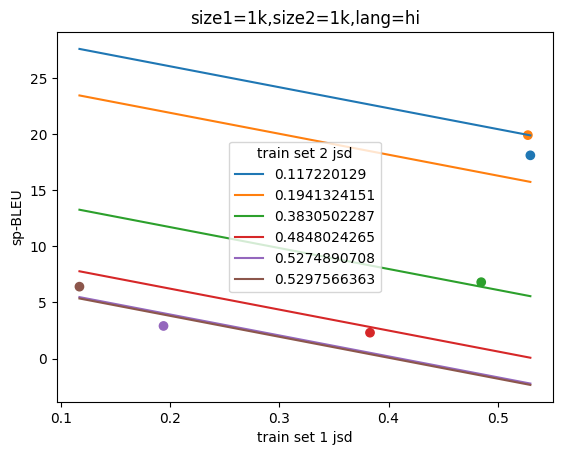

In [9]:
expr = DoubleDomain(linear_double, np.zeros(3), pars=["beta1", "beta2", "C"],
                    trial="trial1", verbose=2)
expr.fit_all()
# expr.read_all_fits()
expr.plot_all()
expr.analyze_all()